In [1]:
##EVASION

In [1]:
import pprint
import numpy as np
import pandas as pd
from sklearn import *
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib.path import Path
from sklearn.utils import class_weight
from matplotlib.patches import PathPatch
from keras.models import Sequential, Model
from sklearn.datasets import make_classification
from art.attacks.evasion import FastGradientMethod
from art.defences.trainer import AdversarialTrainer
from sklearn.model_selection import train_test_split
from art.attacks.evasion import BasicIterativeMethod
from art.defences.postprocessor import ReverseSigmoid
from keras.preprocessing.image import ImageDataGenerator
from art.estimators.classification import KerasClassifier
from art.attacks.extraction import CopycatCNN, KnockoffNets
from art.estimators.classification import TensorFlowV2Classifier
from keras.layers import Conv2D, MaxPooling2D, InputLayer, Reshape
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.python.framework.ops import disable_eager_execution

In [2]:
tf.compat.v1.disable_eager_execution()

In [3]:
path = ("malimg_paper_dataset_imgs")

In [4]:
path_images = ImageDataGenerator().flow_from_directory(directory=path, target_size=(128,128), batch_size=10000)

Found 9339 images belonging to 25 classes.


In [5]:
images, marks = next(path_images)

In [6]:
#Entrenamiento - Pruebas

In [7]:
X_train, X_test0, y_train, y_test0 = train_test_split(images, marks, test_size = 0.2)

In [8]:
# TRAIN

In [9]:
X_train.shape

(7471, 128, 128, 3)

In [12]:
y_train.shape

(7471, 25)

In [16]:
X_train.size

367214592

In [17]:
y_train.size

186775

In [13]:
# TEST

In [14]:
X_test0.shape

(1868, 128, 128, 3)

In [15]:
y_test0.shape

(1868, 25)

In [18]:
X_test0.size

91815936

In [19]:
y_test0.size

46700

In [20]:
print('Images size --> ', images.itemsize)
print('Marks --> ',marks.itemsize)

Images size -->  4
Marks -->  4


In [21]:
images

array([[[[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [ 54.,  54.,  54.],
         [  0.,   0.,   0.],
         ...,
         [127., 127., 127.],
         [  0.,   0.,   0.],
         [127., 127., 127.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        ...,

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[  0.,   0.,   0.],
       

In [22]:
marks

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [23]:
## MODELO ORIGINAL

In [26]:
model_ev = keras.Sequential()
model_ev.add(keras.layers.Conv2D(32, (5, 5), input_shape=(128, 128, 3), activation='relu', padding='same'))
model_ev.add(keras.layers.MaxPooling2D(2))
model_ev.add(keras.layers.Dropout(0.2))
model_ev.add(keras.layers.BatchNormalization())
model_ev.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model_ev.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
model_ev.add(keras.layers.Flatten())
model_ev.add(keras.layers.Dense(128, activation='relu'))
model_ev.add(keras.layers.Dense(25, activation='softmax'))

In [27]:
# Compile
# https://faroit.com/keras-docs/2.1.3/models/sequential/
model_ev.compile(loss='categorical_crossentropy',optimizer='SGD',metrics=['accuracy'])

In [28]:
model_ev.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 60, 60, 128)       73856     
_________________________________________________________________
flatten_1 (Flatten)          (None, 460800)           

In [29]:
model_ev.fit(X_train, y_train, batch_size=10, validation_data=(X_test0, y_test0), epochs=5)

Train on 7471 samples, validate on 1868 samples
Epoch 1/5
7471/7471 [==============================] - ETA: 0s - loss: 0.4041 - accuracy: 0.8901

C:\Users\sarit\AppData\Roaming\Python\Python38\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


7471/7471 [==============================] - 286s 38ms/sample - loss: 0.4041 - accuracy: 0.8901 - val_loss: 0.1223 - val_accuracy: 0.9647
Epoch 2/5
7471/7471 [==============================] - 296s 40ms/sample - loss: 0.0761 - accuracy: 0.9738 - val_loss: 0.0848 - val_accuracy: 0.9695
Epoch 3/5
7471/7471 [==============================] - 310s 42ms/sample - loss: 0.0387 - accuracy: 0.9872 - val_loss: 0.0740 - val_accuracy: 0.9791
Epoch 4/5
7471/7471 [==============================] - 320s 43ms/sample - loss: 0.0079 - accuracy: 0.9987 - val_loss: 0.0615 - val_accuracy: 0.9823
Epoch 5/5
7471/7471 [==============================] - 326s 44ms/sample - loss: 0.0019 - accuracy: 0.9999 - val_loss: 0.0616 - val_accuracy: 0.9845


In [31]:
model_ev_class = KerasClassifier(model, clip_values=(0, 1), use_logits=False)

In [34]:
x_test_pred = np.argmax(model_ev_class.predict(X_test0), axis=1)
nb_correct_pred = np.sum(x_test_pred == np.argmax(y_test0, axis=1))

print("Clasificados correctamente: {}".format(nb_correct_pred))
print("Clasificados incorrectamente: {}".format(len(X_test0)-nb_correct_pred))
print("Porcentaje: {}".format(nb_correct_pred/len(X_test0)))

Clasificados correctamente: 29
Clasificados incorrectamente: 1839
Porcentaje: 0.015524625267665952


In [35]:
#Evasion FGM

In [36]:
attacker = FastGradientMethod(model_ev_class, eps=100)
x_test_adv = attacker.generate(X_test0)

In [38]:
x_test_adv_pred = np.argmax(model_ev_class.predict(x_test_adv), axis=1)
nb_correct_adv_pred = np.sum(x_test_adv_pred == np.argmax(y_test0, axis=1))

print("Clasificados correctamente: {}".format(nb_correct_adv_pred))
print("Clasificados incorrectamente: {}".format(len(X_test0)-nb_correct_adv_pred))
print("Porcentaje: {}".format(nb_correct_adv_pred/len(X_test0)))

Clasificados correctamente: 34
Clasificados incorrectamente: 1834
Porcentaje: 0.018201284796573874


In [44]:
##MODELO ROBUSTO

In [40]:
modelR = Sequential()
modelR.add(keras.layers.Rescaling(1./255, input_shape=(128, 128, 3)))
modelR.add(keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'))
modelR.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
modelR.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
modelR.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
modelR.add(keras.layers.Flatten())
modelR.add(keras.layers.Dense(1024, activation='relu'))
modelR.add(keras.layers.Dense(25, activation='softmax'))

In [42]:
modelR.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [43]:
print("Original model training:")
modelR.fit(X_train, y_train, batch_size=10, epochs=5)
print("Original model evaluation:")
print(modelR.evaluate(X_test0, y_test0))


Original model training:
Train on 7471 samples
Epoch 1/5
7471/7471 [==============================] - 249s 33ms/sample - loss: 0.4614 - accuracy: 0.8957
Epoch 2/5
7471/7471 [==============================] - 270s 36ms/sample - loss: 0.0977 - accuracy: 0.9710
Epoch 3/5
7471/7471 [==============================] - 255s 34ms/sample - loss: 0.0682 - accuracy: 0.9786
Epoch 4/5
7471/7471 [==============================] - 248s 33ms/sample - loss: 0.0531 - accuracy: 0.9829
Epoch 5/5
7471/7471 [==============================] - 244s 33ms/sample - loss: 0.0428 - accuracy: 0.9877
Original model evaluation:
[0.1183953982572484, 0.9652034]


In [65]:
robust_class = KerasClassifier(modelR, clip_values=(0, 1), use_logits=False)

In [66]:
## Ataque

In [67]:
# attacks = BasicIterativeMethod(robust_class, eps=60, eps_step=2, max_iter=40)
# trainer = AdversarialTrainer(robust_class, attacks, ratio=1.0)
# trainer.fit(X_train, y_train, nb_epochs=5, batch_size=100)

In [53]:
x_test_robust_pred = np.argmax(robust_class.predict(X_test0), axis=1)
nb_correct_robust_pred = np.sum(x_test_robust_pred == np.argmax(y_test0, axis=1))

print("Clasificados correctamente: {}".format(nb_correct_robust_pred))
print("Clasificados incorrectamente: {}".format(len(X_test0)-nb_correct_robust_pred))
print("Porcentaje: {}".format(nb_correct_robust_pred/len(X_test0)))

Clasificados correctamente: 1611
Clasificados incorrectamente: 257
Porcentaje: 0.8624197002141327


In [69]:
#FGM
robust_attacker = FastGradientMethod(robust_class, eps=100)
x_test_adv = Rattacker.generate(X_test0)

In [70]:
x_test_adv_robust_pred = np.argmax(robust_class.predict(x_test_adv), axis=1)
nb_correct_adv_robust_pred = np.sum(x_test_adv_robust_pred == np.argmax(y_test0, axis=1))

# print("Clasificados correctamente: {}".format(nb_correct_adv_robust_pred))
# print("Clasificados incorrectamente: {}".format(len(x_test0)-nb_correct_adv_robust_pred))
# print("Porcentaje: {}".format(nb_correct_adv_robust_pred/len(x_test0)))

In [76]:
eps_range = [1, 2, 3, 4, 5, 10, 20, 30]
nb_correct_original = []
nb_correct_robust = []

for eps in eps_range:
    attacker.set_params(**{'eps': eps})
    robust_attacker.set_params(**{'eps': eps})
    x_test_adv = attacker.generate(X_test0)
    x_test_adv_robust = robust_attacker.generate(X_test0)
    
    x_test_adv_pred = np.argmax(model_ev_class.predict(x_test_adv), axis=1)
    nb_correct_original += [np.sum(x_test_adv_pred == np.argmax(y_test0, axis=1))]
    
    x_test_adv_robust_pred = np.argmax(robust_class.predict(x_test_adv_robust), axis=1)
    nb_correct_robust += [np.sum(x_test_adv_robust_pred == np.argmax(y_test0, axis=1))]

eps_range = [0] + eps_range
nb_correct_original = [nb_correct_pred] + nb_correct_original
nb_correct_robust = [nb_correct_robust_pred] + nb_correct_robust

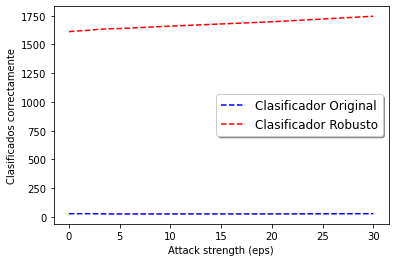

In [79]:
#Grafica
fig, ax = plt.subplots()
ax.plot(np.array(eps_range), np.array(nb_correct_original), 'b--', label='Clasificador Original')
ax.plot(np.array(eps_range), np.array(nb_correct_robust), 'r--', label='Clasificador Robusto')

legend = ax.legend(shadow=True, fontsize='large')
legend.get_frame().set_facecolor('white')

plt.xlabel('Attack strength (eps)')
plt.ylabel('Clasificados correctamente')
plt.show()